<a href="https://colab.research.google.com/github/ANJU7159/DAV-WEEK1-LAB/blob/main/Brain_Tumor_Classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification Deep Learning
This notebook implements 3 deep learning classifier using three convolutional neural networks (CNNs), such as:
- DenseNet 201
- ResNet 50
- XceptionNet

A well-known dataset is used to make application of three neural networks obtained from Kaggle.

## Importing Packages

In [1]:
import tensorflow as tf
from sklearn.metrics import *
import seaborn as sns
from os import *
import os, time
import matplotlib.image as mpimg
import numpy as np
import tensorflow_hub as hub
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
# import keras_cv
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import *
from keras.applications.densenet import preprocess_input
from keras.callbacks import Callback
from keras.layers import *
from keras.applications import DenseNet201
from keras.applications import *
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.metrics import Precision, Recall

## Dataset Import Kaggle

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
 83% 89.0M/107M [00:01<00:00, 64.9MB/s]
100% 107M/107M [00:01<00:00, 70.7MB/s] 


In [4]:
# making a directory
!mkdir brain_tumor_data
!unzip '/content/brian-tumor-dataset.zip' -d brain_tumor_data

Archive:  /content/brian-tumor-dataset.zip
  inflating: brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: brain_tumor_data/Brain

## Setting Dataset Directory

In [5]:
data_dir = '/content/brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set'

### Showing Sample Images

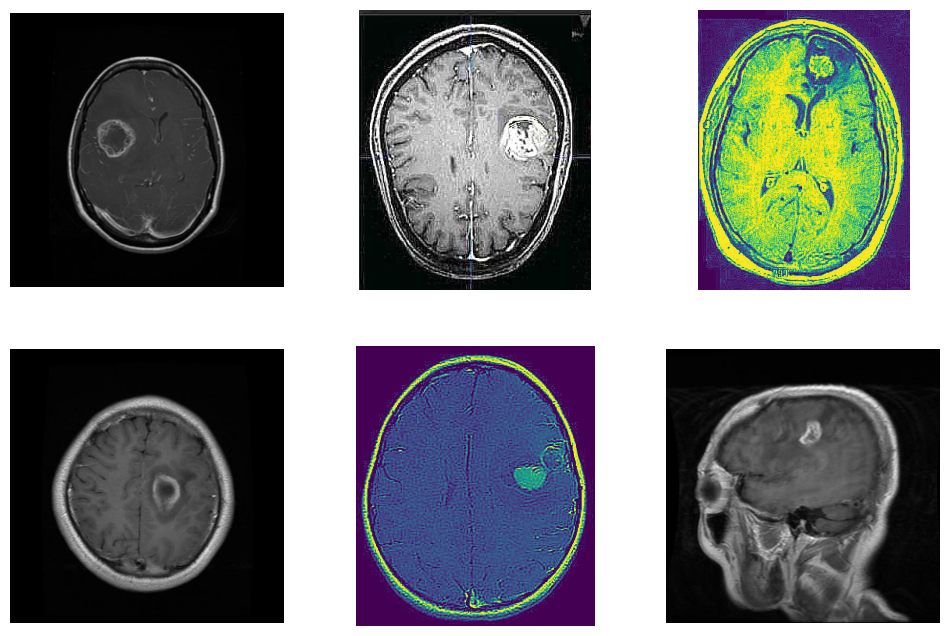

In [6]:
# showing brain tumor images
folder_path = '/content/brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
image_files_tumor = [file for file in os.listdir(folder_path)]

num_images = min(6, len(image_files_tumor))
num_rows = (num_images - 1) // 3 + 1

fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

for i in range(num_images):
    image_path = os.path.join(folder_path, image_files_tumor[i])
    img = mpimg.imread(image_path)
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

# showing images
plt.show()

## Data Augmentation

In [7]:
BATCH_SIZE = 512
X=Y=224

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values
    validation_split=0.2,  # reserve some images for validation
)

# Prepare data generators

train_dataset = datagen.flow_from_directory(
    data_dir,
    target_size=(X, Y),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    interpolation='bilinear', # strategy used for resampling when resizing
    subset='training',
)

validation_dataset = datagen.flow_from_directory(
    data_dir,
    target_size=(X, Y),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    interpolation='bilinear', # strategy used for resampling when resizing
    subset='validation',
)

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [8]:
train_dataset.class_indices

{'Brain Tumor': 0, 'Healthy': 1}

## Making True Labels `Y_True`

In [9]:
steps = validation_dataset.samples // validation_dataset.batch_size
if validation_dataset.samples % validation_dataset.batch_size > 0:
    steps += 1

images_list = []
Y_true = []

for i, (images, labels) in enumerate(validation_dataset):
    if i >= steps:
        break
    images_list.extend(images)
    Y_true.extend(labels)

images_array = np.array(images_list)
Y_true = np.array(Y_true)

In [10]:
# train_generator.next()
Y_true

array([1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 1.

## Helper Functions
We will make helper functions for multiple purposes, such as plotting model's performance, visualizing confusion matrix, etc.

### `plot_training_history()` Function for Plotting Model Results

In [11]:
def plot_training_history(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs = range(1, len(training_accuracy) + 1)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))

    ax1.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
    ax1.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)  # Show grid lines

    ax2.plot(epochs, training_loss, 'bo-', label='Training Loss')
    ax2.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)  # Show grid lines

    plt.tight_layout()
    plt.show()

### `plot_cnfusion_matrix` Function for Confusion Matrix

In [12]:
def plot_cnfusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))

    sns.heatmap(cm,
                annot=True,
                cmap='Blues',
                fmt='d',
                xticklabels=labels,
                yticklabels=labels,
                ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # showing the plot
    plt.tight_layout()
    plt.show()

In [13]:
# defining metrics for model
metrics = [ tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.F1Score(name='F1'),
            tf.keras.metrics.Recall(name='Recall'),
            tf.keras.metrics.Precision(name='Precision')
            ]

## Making Deep Learning Model (DenseNet201)

In [14]:
# initializing DenseNet CNN
dn_201 = DenseNet201 (
        input_shape=(X, Y, 3),
        weights='imagenet',
        include_top=False
        )

# setting trainable to false
dn_201.trainable = False

# global avg pooling layer
x = GlobalAveragePooling2D()(dn_201.output)

# flattening input
x = Flatten()(x)

# dense layer
x = Dense(128, activation='relu')(x)

# dense layer
x = Dense(64, activation='relu')(x)

# output layer
y = Dense(1, activation='sigmoid')(x)

# making model
model_dn_201 = Model(inputs=dn_201.input,
              outputs=y)

74836368/74836368 [==============================] - 0s 0us/step


In [15]:
# model_dn_201.summary()

### Compiling the Model
The model will be compiled using an evaluation metric, optimizer, and loss function. Following settings used to compile the deep learning model:
- Target Metrics
  - Accuracy
  - Precision
  - Recall
  - F1 Score
- Loss Function
  - Binary Crossentropy (Since there are 2 classes)
- Optimizer
  - Adam (Learning Rate = 0.001)


In [16]:
optimizer = tf.keras.optimizers.RMSprop()

model_dn_201.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=metrics)

### Fitting the Model

In [17]:
# train the model on dataset
%%time
history = model_dn_201.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    verbose=1)

Epoch 1/20
8/8 [==============================] - 197s 24s/step - loss: 0.8746 - accuracy: 0.6468 - F1: 0.6242 - Recall: 0.5401 - Precision: 0.6290 - val_loss: 0.5107 - val_accuracy: 0.7421 - val_F1: 0.6243 - val_Recall: 0.5108 - val_Precision: 0.8659
Epoch 2/20
8/8 [==============================] - 28s 3s/step - loss: 0.5295 - accuracy: 0.7362 - F1: 0.6242 - Recall: 0.7317 - Precision: 0.7003 - val_loss: 0.5382 - val_accuracy: 0.6899 - val_F1: 0.6243 - val_Recall: 0.3261 - val_Precision: 0.9714
Epoch 3/20
8/8 [==============================] - 28s 3s/step - loss: 0.4261 - accuracy: 0.7927 - F1: 0.6242 - Recall: 0.7707 - Precision: 0.7720 - val_loss: 0.4350 - val_accuracy: 0.7911 - val_F1: 0.6243 - val_Recall: 0.5803 - val_Precision: 0.9344
Epoch 4/20
8/8 [==============================] - 28s 3s/step - loss: 0.3508 - accuracy: 0.8487 - F1: 0.6242 - Recall: 0.8162 - Precision: 0.8450 - val_loss: 0.5878 - val_accuracy: 0.6888 - val_F1: 0.6243 - val_Recall: 0.3189 - val_Precision: 0.985

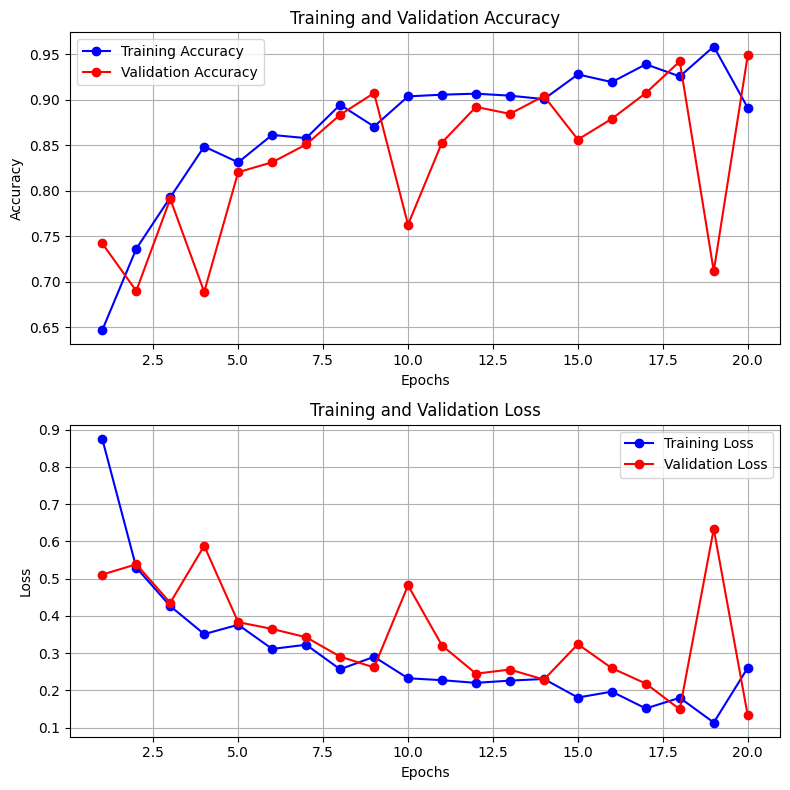

In [18]:
plot_training_history(history)

In [19]:
# evaluate the model (accuracy, loss)
test_loss, test_acc_dn, _, _, _ = model_dn_201.evaluate(validation_dataset, verbose=0)
print("Test accuracy of DenseNet 201: %.2f%%" % ((test_acc_dn)*100))

Test accuracy of DenseNet 201: 94.89%


### Making Predictions (DenseNet 201)

In [20]:
y_pred = model_dn_201.predict(images_array, verbose=0)
# y_pred = y_pred.reshape(-1,)
# y_pred_dn_201 = np.float16(y_pred>=0.5)

In [21]:
threshold = 0.5
y_pred_dn_201 = (y_pred[:, 0] >= threshold).astype(int)

In [22]:
# y_pred_dn_201

In [23]:
cr_dn_201 = classification_report(Y_true, y_pred_dn_201)
print("Classification Report of DenseNet 201")
print(cr_dn_201)

Classification Report of DenseNet 201
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       502
         1.0       0.92      0.97      0.95       417

    accuracy                           0.95       919
   macro avg       0.95      0.95      0.95       919
weighted avg       0.95      0.95      0.95       919



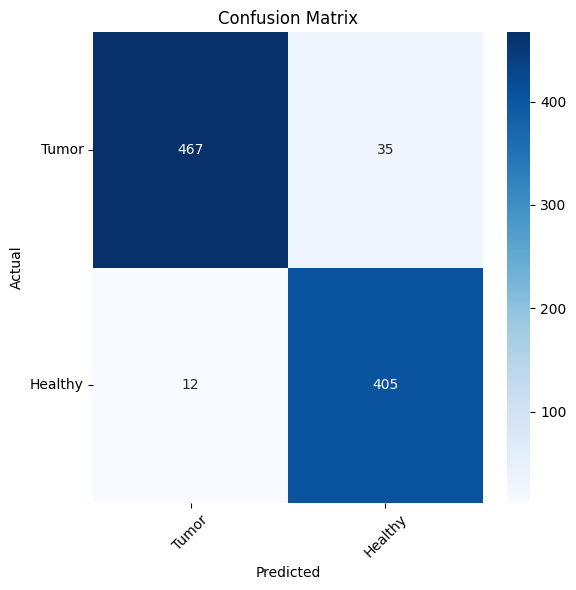

In [24]:
labels = ['Tumor', 'Healthy']
plot_cnfusion_matrix(Y_true, y_pred_dn_201, labels)

## Applying ResNet 50 CNN

In [25]:
# initializing resnet 50 cnn model
rn_50 = ResNet50 (
        input_shape=(X, Y, 3),
        weights='imagenet',
        include_top=False
        )

# setting trainable to false
rn_50.trainable = False

x = GlobalAveragePooling2D()(rn_50.output)

# flattening the input
x = Flatten()(x)

# dense layer
x = Dense(128, activation='relu')(x)

# dense layer
x = Dense(64, activation='relu')(x)

# output layer
y = Dense(1, activation='sigmoid')(x)

# making model
model_rn_50 = Model(inputs=rn_50.input,
              outputs=y)

94765736/94765736 [==============================] - 1s 0us/step


In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_rn_50.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=metrics)

In [27]:
# fitting model (resnet 50)
%%time
history_rn50=model_rn_50.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    verbose=1)

Epoch 1/20
8/8 [==============================] - 83s 6s/step - loss: 0.6878 - accuracy: 0.6228 - F1: 0.6242 - Recall: 0.4696 - Precision: 0.6095 - val_loss: 0.6732 - val_accuracy: 0.5985 - val_F1: 0.6243 - val_Recall: 0.4844 - val_Precision: 0.5674
Epoch 2/20
8/8 [==============================] - 26s 3s/step - loss: 0.6352 - accuracy: 0.6822 - F1: 0.6242 - Recall: 0.4455 - Precision: 0.7530 - val_loss: 0.6602 - val_accuracy: 0.6148 - val_F1: 0.6243 - val_Recall: 0.4748 - val_Precision: 0.5946
Epoch 3/20
8/8 [==============================] - 25s 3s/step - loss: 0.6018 - accuracy: 0.6985 - F1: 0.6242 - Recall: 0.5150 - Precision: 0.7414 - val_loss: 0.6564 - val_accuracy: 0.6387 - val_F1: 0.6243 - val_Recall: 0.6091 - val_Precision: 0.6005
Epoch 4/20
8/8 [==============================] - 27s 3s/step - loss: 0.5852 - accuracy: 0.7142 - F1: 0.6242 - Recall: 0.5737 - Precision: 0.7381 - val_loss: 0.6462 - val_accuracy: 0.6594 - val_F1: 0.6243 - val_Recall: 0.6139 - val_Precision: 0.6275


In [28]:
# evaluate the model (accuracy, loss)
test_loss, test_acc_rn, _, _, _ = model_rn_50.evaluate(validation_dataset, verbose=0)
print("Test accuracy of ResNet50: %.2f%%" % ((test_acc_rn)*100))

Test accuracy of ResNet50: 71.82%


### Visualizing Model Results (ResNet 50)

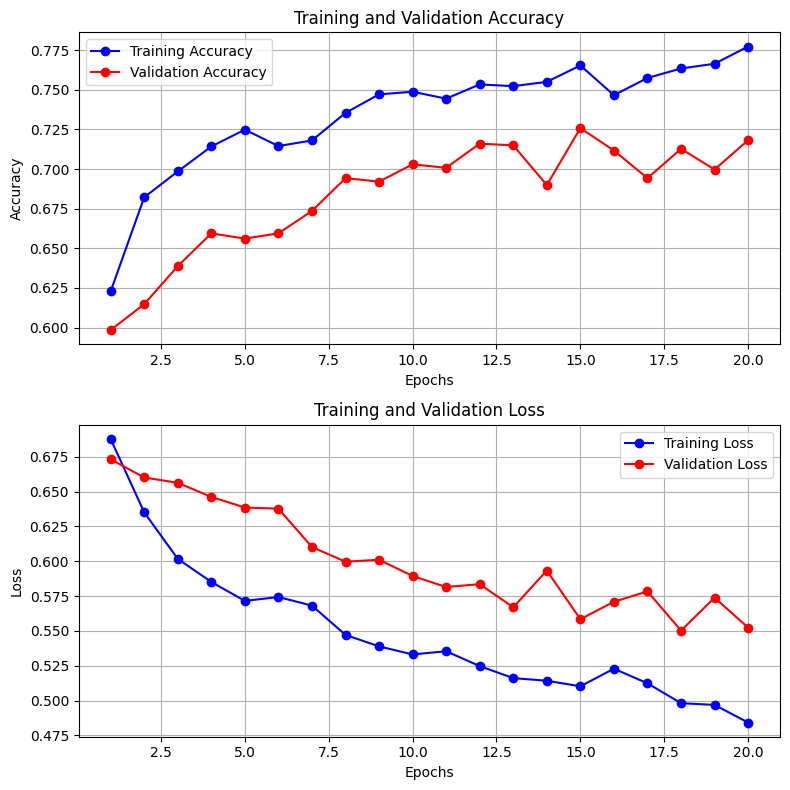

In [29]:
plot_training_history(history_rn50)

In [30]:
y_pred_rn = model_rn_50.predict(images_array, verbose=0)
threshold = 0.5
y_pred_rn_50 = (y_pred_rn[:, 0] >= threshold).astype(int)

In [31]:
cr_rn_50 = classification_report(Y_true, y_pred_rn_50)
print("Classification Report of ResNet 50")
print(cr_rn_50)

Classification Report of ResNet 50
              precision    recall  f1-score   support

         0.0       0.76      0.72      0.73       502
         1.0       0.68      0.72      0.70       417

    accuracy                           0.72       919
   macro avg       0.72      0.72      0.72       919
weighted avg       0.72      0.72      0.72       919



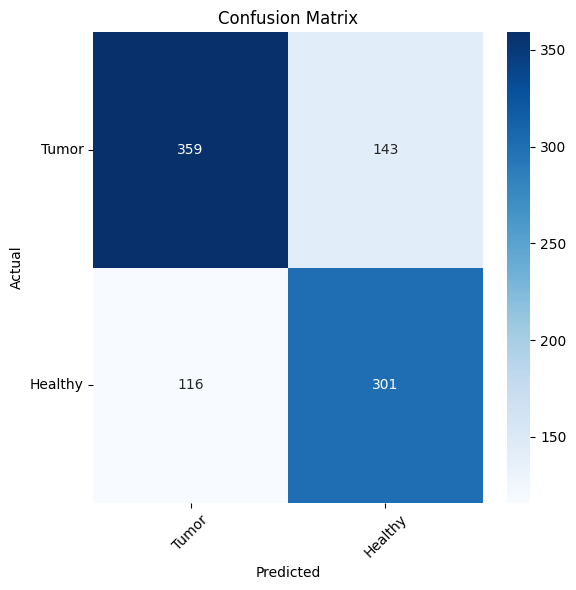

In [32]:
labels = ['Tumor', 'Healthy']
plot_cnfusion_matrix(Y_true, y_pred_rn_50, labels)

## Applying XceptionNet

In [33]:
# initializing XceptionNet CNN model
x_net = Xception(
        input_shape=(X, Y, 3),
        weights='imagenet',
        include_top=False
        )

# setting trainable to false
x_net.trainable = False

# global avg pooling layer
x = GlobalAveragePooling2D()(x_net.output)

# flattening input
x = Flatten()(x)

# dense layer
x = Dense(128, activation='relu')(x)

# dense layer
x = Dense(64, activation='relu')(x)

# output layer
y = Dense(1, activation='sigmoid')(x)

# making model
model_x_net = Model(inputs=x_net.input,
              outputs=y)

83683744/83683744 [==============================] - 0s 0us/step


In [34]:
optimizer = tf.keras.optimizers.RMSprop()

model_x_net.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=metrics)

In [35]:
# fitting the model
%%time
history_xc=model_x_net.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    verbose=1)

Epoch 1/15
8/8 [==============================] - 115s 14s/step - loss: 0.7674 - accuracy: 0.6591 - F1: 0.6242 - Recall: 0.5017 - Precision: 0.6648 - val_loss: 0.5407 - val_accuracy: 0.7269 - val_F1: 0.6243 - val_Recall: 0.4892 - val_Precision: 0.8430
Epoch 2/15
8/8 [==============================] - 28s 4s/step - loss: 0.4948 - accuracy: 0.7441 - F1: 0.6242 - Recall: 0.7251 - Precision: 0.7149 - val_loss: 0.4698 - val_accuracy: 0.7835 - val_F1: 0.6243 - val_Recall: 0.6115 - val_Precision: 0.8733
Epoch 3/15
8/8 [==============================] - 28s 3s/step - loss: 0.4296 - accuracy: 0.8009 - F1: 0.6242 - Recall: 0.7557 - Precision: 0.7952 - val_loss: 0.4409 - val_accuracy: 0.7954 - val_F1: 0.6243 - val_Recall: 0.5947 - val_Precision: 0.9288
Epoch 4/15
8/8 [==============================] - 28s 4s/step - loss: 0.3535 - accuracy: 0.8490 - F1: 0.6242 - Recall: 0.8353 - Precision: 0.8323 - val_loss: 0.3435 - val_accuracy: 0.8672 - val_F1: 0.6243 - val_Recall: 0.7914 - val_Precision: 0.904

In [39]:
# evaluate the model (accuracy, loss)
test_loss, test_acc_xc, _, _, _ = model_x_net.evaluate(validation_dataset, verbose=0)
print("Test accuracy of XceptionNet: %.2f%%" % ((test_acc_xc)*100))

Test accuracy of XceptionNet: 92.93%


### Visualizing Model Performance

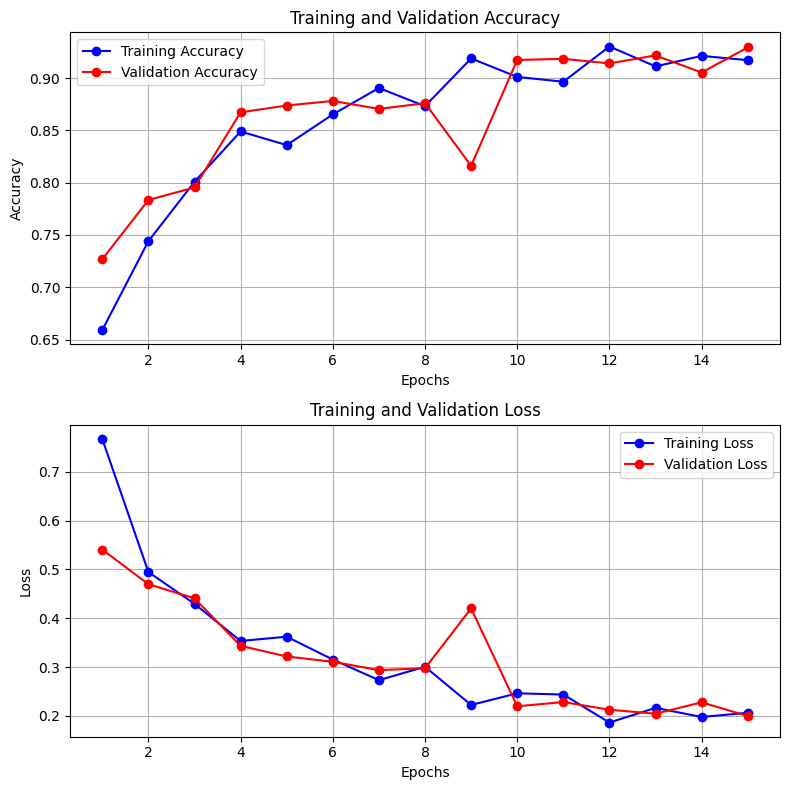

In [40]:
# plot graphs (xception)
plot_training_history(history_xc)

In [42]:
y_pred_xc = model_x_net.predict(images_array, verbose=0)
threshold = 0.5
y_pred_xc = (y_pred_xc[:, 0] >= threshold).astype(int)

In [43]:
cr_xc = classification_report(Y_true, y_pred_xc)
print("Classification Report of Xception")
print(cr_xc)

Classification Report of Xception
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       502
         1.0       0.89      0.96      0.93       417

    accuracy                           0.93       919
   macro avg       0.93      0.93      0.93       919
weighted avg       0.93      0.93      0.93       919



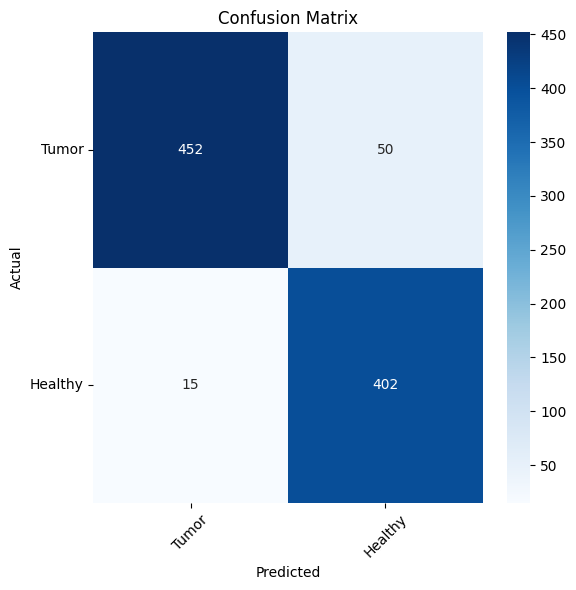

In [44]:
plot_cnfusion_matrix(Y_true, y_pred_xc, labels)

## Comparing Models

In [45]:
def plot_accuracy_comparison(models, accuracies):
    bar_width = 0.4

    positions = range(len(models))

    fig, ax = plt.subplots(figsize=(8, 6))

    bars = ax.bar(positions, accuracies, bar_width, color='gray')

    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy')
    ax.set_title('Comparison of Models (Brain Tumor Dataset)')
    ax.set_xticks(positions)
    ax.set_xticklabels(models, rotation=45, ha='right')

    # adding the accuracies as annotations above the bars
    for bar, accuracy in zip(bars, accuracies):
      accuracy_percentage = accuracy * 100
      ax.annotate(f'{accuracy_percentage:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')


    plt.tight_layout()
    plt.show()

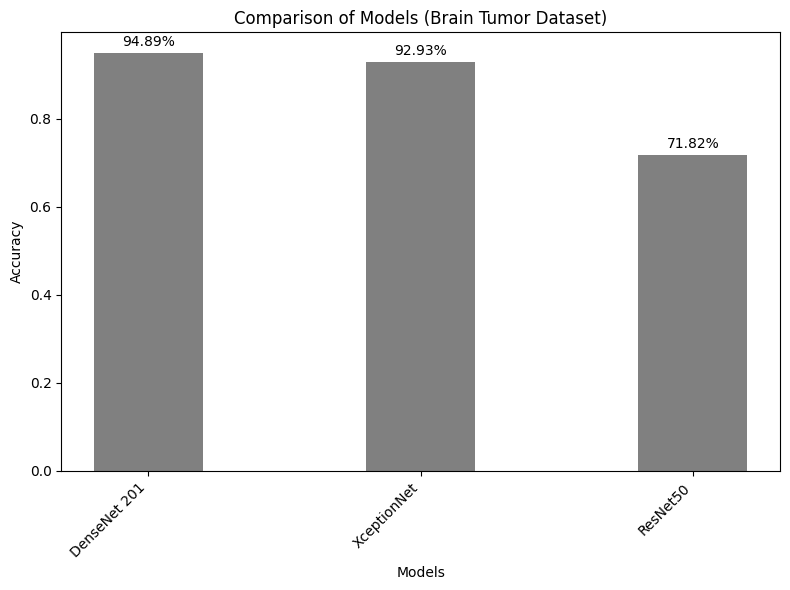

In [46]:
models = ['DenseNet 201', 'XceptionNet', 'ResNet50']
accuracies = [test_acc_dn, test_acc_xc, test_acc_rn]
plot_accuracy_comparison(models, accuracies)